In [ ]:
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 6.6MB 4.9MB/s 
     |████████████████████████████████| 2.2MB 7.0MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200716-cp36-none-any.whl size=42325 sha256=ebf183208a31eb62c99dc36eff792785c7848dea79cdafe5733105fbe765cc74
  Stored in directory: /root/.cache/pip/wheels/81/99/f4/42a6bef61c07b3d78dfe6d7ebff259444c4526504cf72378d7
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [ ]:

import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.modeling import build_model
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from google.colab import files

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
start = 'drive/My Drive/'

In [ ]:
!cp drive/My\ Drive/cigs/images/*.png drive/My\ Drive/cigs/val

In [ ]:
img_dir = start+'cigs/train'

json_file = os.path.join(img_dir, "instances_images.json")
with open(json_file) as f:
  imgs_anns = json.load(f)

dataset_dicts = []

In [ ]:

register_coco_instances("my_dataset_train", {}, start+"cigs/train/instances_images.json",start+'cigs/train/')
register_coco_instances("my_dataset_val", {}, start+"cigs/val/coco_annotations.json", start + 'cigs/val')

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val")
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025 
cfg.SOLVER.MAX_ITER = 1000   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[08/17 12:53:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_a3ec72.pkl: 254MB [00:21, 11.9MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to i

[08/17 12:54:00 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/structures/masks.py:331: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.6/dist-packages/detectron2/structures/masks.py:331: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.6/dist-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_

[08/17 12:54:30 d2.utils.events]:  eta: 0:24:12  iter: 19  total_loss: 1.391  loss_cls: 0.581  loss_box_reg: 0.102  loss_mask: 0.688  loss_rpn_cls: 0.003  loss_rpn_loc: 0.002  time: 1.4515  data_time: 0.0409  lr: 0.000005  max_mem: 2717M
[08/17 12:55:00 d2.utils.events]:  eta: 0:23:23  iter: 39  total_loss: 1.250  loss_cls: 0.475  loss_box_reg: 0.114  loss_mask: 0.670  loss_rpn_cls: 0.003  loss_rpn_loc: 0.002  time: 1.4547  data_time: 0.0063  lr: 0.000010  max_mem: 2717M
[08/17 12:55:29 d2.utils.events]:  eta: 0:22:49  iter: 59  total_loss: 1.080  loss_cls: 0.317  loss_box_reg: 0.118  loss_mask: 0.635  loss_rpn_cls: 0.005  loss_rpn_loc: 0.002  time: 1.4520  data_time: 0.0056  lr: 0.000015  max_mem: 2717M
[08/17 12:55:58 d2.utils.events]:  eta: 0:22:32  iter: 79  total_loss: 0.929  loss_cls: 0.225  loss_box_reg: 0.124  loss_mask: 0.589  loss_rpn_cls: 0.004  loss_rpn_loc: 0.002  time: 1.4567  data_time: 0.0068  lr: 0.000020  max_mem: 2717M
[08/17 12:56:27 d2.utils.events]:  eta: 0:21:57 

KeyError: ignored

In [ ]:
cfg.MODEL.WEIGHTS = "./output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)


In [ ]:
cfg.OUTPUT_DIR

'./output'

In [ ]:
files.download(os.path.join(cfg.OUTPUT_DIR, "model_final.pth"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%cp output/model_final.pth drive/My\ Drive/

In [ ]:
sigs = os.listdir(start+'cig_butts/tuintest/')

In [ ]:
sigs

['116911346_380423566271413_4013162191470498040_n.jpg',
 '116713457_420266778900307_4706564084544499232_n.jpg',
 '116705236_644962442781002_7266905837026673307_n.jpg',
 '116797195_1200866393617663_8588970806879034049_n.jpg',
 '116971699_210229173755508_8091285428973174320_n.jpg',
 '116705590_328140581564167_9153218265255994875_n.jpg',
 '116789084_577700813133837_2045126979349092_n.jpg',
 'cigr.jpg',
 'cigt.jpg',
 'cigv.jpg',
 'cigp.jpg',
 '117236499_619763755585990_2728257908572102067_n.jpg',
 '1538100671530.jpg',
 '117209885_295508761510375_5457040462099603741_n.jpg',
 'cigarettebut.jpg',
 'tested.jpg',
 'tested1.jpg']

In [ ]:
im = cv2.imread(start+'cig_butts/tuintest/'+sigs[2])
im = cv2.resize(im, (512,512))
cv2_imshow(im)
outputs = predictor(im)
outputs

NameError: ignored

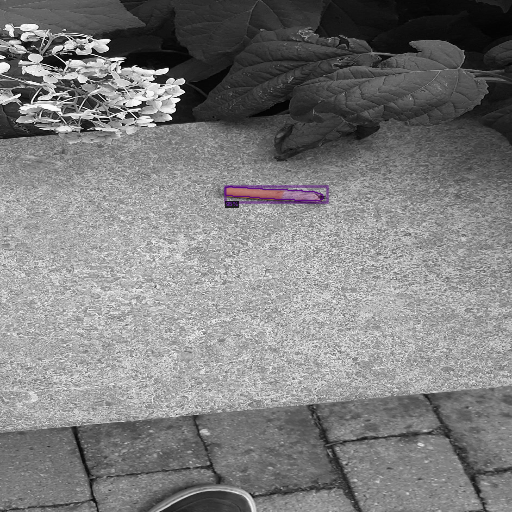

In [ ]:
v = Visualizer(im[:, :, ::-1], scale=1, 
               instance_mode=ColorMode.IMAGE_BW)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
model = build_model(cfg)
torch.save(model.state_dict(), 'model_final.pth')

In [ ]:
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="/output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

inference_on_dataset(trainer.model, val_loader, evaluator)

[08/17 13:42:57 d2.data.datasets.coco]: Loaded 200 images in COCO format from drive/My Drive/cigs/val/coco_annotations.json
[08/17 13:42:58 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  cig_butt  | 200          |
|            |              |
[08/17 13:42:58 d2.data.common]: Serializing 200 elements to byte tensors and concatenating them all ...
[08/17 13:42:58 d2.data.common]: Serialized dataset takes 0.12 MiB
[08/17 13:42:58 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/17 13:42:58 d2.evaluation.evaluator]: Start inference on 200 images
[08/17 13:43:02 d2.evaluation.evaluator]: Inference done 11/200. 0.3391 s / img. ETA=0:01:07
[08/17 13:43:08 d2.evaluation.evaluator]: Inference done 25/200. 0.3348 s / img. ETA=0:01:05
[08/17 13:43:13 d2.evaluation.evaluator]: Inference done 40/200. 0.3363 s / img. E

OrderedDict([('bbox',
              {'AP': 82.54356761950999,
               'AP50': 98.5717149565446,
               'AP75': 97.7492465703686,
               'APl': nan,
               'APm': 82.44919299978348,
               'APs': 82.5907590759076}),
             ('segm',
              {'AP': 85.32288013434157,
               'AP50': 98.5717149565446,
               'AP75': 98.5717149565446,
               'APl': nan,
               'APm': 85.10603923349166,
               'APs': 82.09168726237172})])